In [1]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
import warnings
import sys, time
try:
    import cPickle as pkl
except:
    import pickle as pkl
import bz2
from tqdm import *

warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)

In [8]:
site_name = 'worldbuilding.stackexchange.com'
site = StackSite(site_name)
site.load()
df_dict = site.df_dict()
#rc = Recommender(site_name, df_dict)
#rc.load('full')

Dataframes successfully loaded.


In [9]:
for name in df_dict.keys():
    print name, len(df_dict[name])

users 4728
comments 20755
answers 6344
questions 1321
tags 266


# Generate K-Fold Test/Train Splits

I'll generate train/test splits for the answers. I'll need to get the question_df.index of the parent_id from each answer the recommender, and the user_id of the answerer. I'll also split comments for training purposes (I want to be somewhat right about this... I'll train on a split corpus).

I'll treat `tags_df` as static (since according to StackExchange, it shouldn't change often), and I don't use `users_df` for anything (future features will allow `user_df` <-> `display_name` conversions).

In [23]:
df_names = ['answers', 'comments']
df_lengths = {name:len(site.df(name)) for name in df_names}
df_lengths

{'answers': 6344, 'comments': 20755}

In [24]:
# generate the train/test split index arrays
n_folds = 2
folds = {name:KFold(df_lengths[name], n_folds=n_folds) for name in df_names}

In [25]:
# generate the train/test dataframes
train_dfs = {name:[] for name in df_names}
test_dfs = {name:[] for name in df_names}
for name in df_names:
    for train, test in folds[name]:
        train_dfs[name].append(site.df(name).ix[train])
        test_dfs[name].append(site.df(name).ix[test])

In [26]:
for j in range(n_folds):
    print len(train_dfs['answers'][j]), len(test_dfs['answers'][j])

3172 3172
3172 3172


In [27]:
train_dfs['answers'][0].head()

user_id parent_id  score  \
post_id                            
6496       4818      6472      2   
6497        687      4629      1   
6498       4816      6407      1   
6499        885      4629      0   
6501        886      6491      8   

                                                    answer  
post_id                                                     
6496     One of the biggest problems is gravity. Mars's...  
6497     Many answers, but I think nanobots as describe...  
6498     First do not start by attempting to shake its ...  
6499     What if the "stuff" itself develops intelligen...  
6501     Aside from Royal Canadian Bandit answer to the...

In [28]:
# split questions_df according to the train/test split of answers_df
train_dfs['questions'] = range(n_folds)
test_dfs['questions'] = range(n_folds)
questions_df = site.df('questions').copy()

for j in range(n_folds):
    train_qids = train_dfs['answers'][j].parent_id.unique().tolist() # indices are already unique
    test_qids = test_dfs['answers'][j].parent_id.unique().tolist() # but df.index is mutable and not hashable
    train_dfs['questions'][j] = questions_df.ix[train_qids]
    test_dfs['questions'][j] = questions_df.ix[test_qids]

In [29]:
# pack the training sets into dictionaries of dataframes for the recommender
df_names.append('questions')
train_df_dicts = range(n_folds)
for j in range(n_folds):
    train_df_dicts[j] = {name:train_dfs[name][j] for name in df_names}
    train_df_dicts[j]['tags'] = site.df('tags')
    train_df_dicts[j]['users'] = site.df('users')

In [30]:
# users and scores are lists of users/scores lists (one list for each fold)
# question_ids is a list of lists of the corresponding question_ids
# questions is a list of lists of questions (one list for each fold)

users = [answers_df.user_id for answers_df in test_dfs['answers']]
scores = [answers_df.score for answers_df in test_dfs['answers']]
question_ids = [answers_df.parent_id for answers_df in test_dfs['answers']]
questions = range(n_folds)
for j in range(n_folds):
    questions[j] = [test_dfs['questions'][j][['title','question','tags']].ix[qid] for qid in question_ids[j]]
    
# make a list of dataframes
validate_dfs = range(n_folds)
for j in range(n_folds):
    validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
    validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
    validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])

In [31]:
for i in range(n_folds):
    validate_dfs[i]['predicted_score'] = 0.
    validate_dfs[i]['support'] = 0.

# Validate

In [35]:
len(validate_dfs[0]), len(train_df_dicts[0]['questions'])

(3172, 718)

In [32]:
%%time
for i in range(n_folds):
    print "\nTraining..."
    sys.stdout.flush()
    recommender = Recommender(site_name,train_df_dicts[i])
    %time recommender.train()
    print "Predicting fold", i+1
    sys.stdout.flush()
    for j in trange(len(validate_dfs[i]), leave = True):
        pred_score, supp = recommender.predict_score(validate_dfs[i].user_id.irow(j),j)
        validate_dfs[i]['predicted_score'][j] = pred_score
        validate_dfs[i]['support'][j] = supp


Training...
 ...created the dictionary.
 ...vectorized the corpus.
 ...training the LDA model on 20 topics in 1 passes and 1000 iterations.


 ...trained the LDA model.
 ...computed similarity matrics.
Done training!
CPU times: user 2min 1s, sys: 1.15 s, total: 2min 2s
Wall time: 1min 18s
Predicting fold 1
|##--------| 719/3172  22% [elapsed: 03:02 left: 10:22,  3.94 iters/sec]

IndexError: index 721 is out of bounds for axis 0 with size 718

*Timing Results*
---

**Pre-vectorize**

*DigitalOcean*

    single core LDA: Wall time: 41min 4s
    multicore LDA: 
    
**Post-Vectorize**
    
*Laptop*

    single core LDA: 

# Make Some Pictures!

In [69]:
import sklearn.metrics

In [70]:
sklearn.metrics.r2_score?

In [93]:
def scale(x):
    return x

def print_error(results, reg = 9.):
    """ 
    Regularized relative squared error (mean and std).
    a_df = answers_df (for the histogram of answer scores from multi-answerers.
    """    
    print "\nMSE: ", sklearn.metrics.mean_squared_error(scale(results1.actual), scale(results1.predicted))
    print "MAE: ", sklearn.metrics.mean_absolute_error(scale(results1.actual), scale(results1.predicted))
    print "R^2", sklearn.metrics.r2_score(scale(results1.actual), scale(results1.predicted))
    
    return

def plot_results(results, title, a_df = None, hist_actual = True, supp_threshold = 3, xlim = None, ylim = None):
    
    color1 = dark2_colors[1]
    color2 = dark2_colors[2]
    color3 = dark2_colors[4]
    
    grouped_results = results.groupby('actual')
    
    plt.figure(figsize=(15,6))
    plt.suptitle(title)    
    
    plt.subplot(121)
    plt.plot(grouped_results.predicted.mean().index, scale(grouped_results.predicted.mean()), label = "Mean Predicted Score")
    plt.scatter(scale(results.actual), scale(results.predicted),
                alpha = 0.1, s = 50, label = "Scores")
    plt.xlabel('Actual Answer Score')
    plt.ylabel('Predicted Score')
    if xlim:
        plt.xlim(-1,xlim)
    else: plt.xlim(scale(results.actual.min()),scale(results.actual.max()))
    if ylim:
        plt.ylim(-1,ylim)
    else: plt.ylim(scale(results.predicted.min()),scale(results.predicted.max()))
    x = np.linspace(min(scale(results.actual.min()),scale(results.predicted.min())), 
                       max(scale(results.actual.max()),scale(results.predicted.max())))
    plt.plot(x,x,'r-', alpha = 0.3, label = r'$100\%$ Accuracy')
    plt.legend(loc='upper left')
    remove_border()

    plt.subplot(122)
    bins = np.linspace(scale(results.predicted.min()),scale(results.predicted.max()),32)
    if hist_actual:
        plt.hist(scale(results.actual), bins = bins, alpha = 0.5, label="Actual", color = color1)
        
    if a_df is not None:
        results.actual.hist(bins = bins, alpha = 0.1, label="Actual", color = color1)
        #here's a historgram of the scores from users who answered more than one question (where I had a chance)
        min_questions_answered = 3
        user_answers = a_df.groupby('user_id')
        multi_answerers = user_answers.score.mean()[user_answers.score.count() >= min_questions_answered].index
        malist = set(multi_answerers.tolist())
        xh, yh, oh = plt.hist(a_df[a_df.user_id.isin(malist)].score, bins = bins, 
                                                   alpha = 0.5, color=color2,
                                                   label="Actual (supp > %d)" % (supp_threshold - 1))

        plt.ylim(0, 1.1 * max(xh))

    plt.hist(scale(results.predicted), bins = bins, alpha = 0.5, label="Predicted", color=color3)
    plt.legend(loc='upper right')
    remove_border()
    
    plt.show()
    
    print_error(results1)
    
    return

LDA

    num_topics = 20
    iterations = 100
    passes = 3
    k = 7
    w = [1,1,1] (title, question, tags)

In [94]:
results1 = pd.DataFrame(columns=['actual','predicted','support'])
results1.actual = pd.concat([vdf.score for vdf in validate_dfs])
results1.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])
results1.support = pd.concat([vdf.support for vdf in validate_dfs])

In [95]:
with bz2.BZ2File('data/'+site_name+'/five-fold-results_100it-3ps-20tp.bzpkl','wb') as f:
    pkl.dump(results1, f)

In [96]:
print len(results1[results1.predicted.isnull()]), recommender.avg_new_user_score
print results1.head()

0 2.0
           actual  predicted  support
parent_id                            
5               3   1.000000        0
7               8   1.000000        0
19             13   4.000000        0
7               5   1.555367        2
22             13   4.000000        0


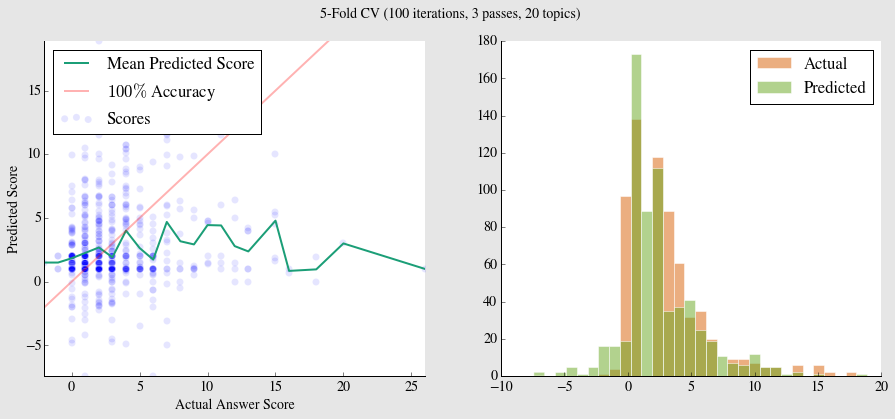


MSE:  17.9618472913
MAE:  2.97776792456
R^2 -0.630954916908


In [100]:
def scale(x): return x
plot_results(results1, '5-Fold CV (100 iterations, 3 passes, 20 topics)')

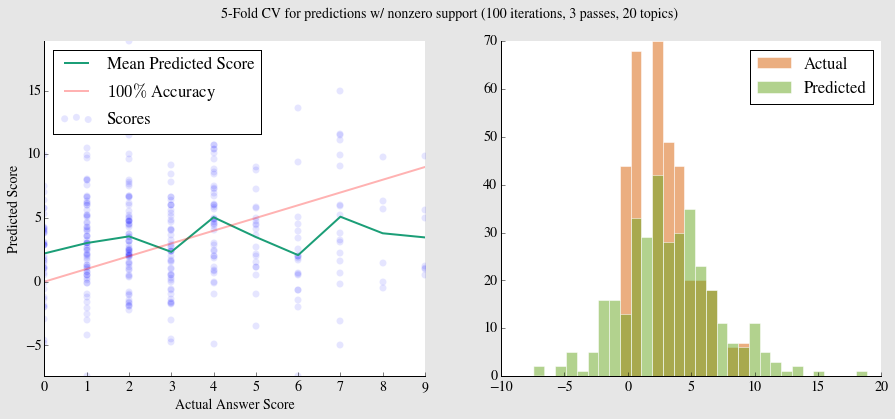


MSE:  17.9618472913
MAE:  2.97776792456
R^2 -0.630954916908


In [98]:
plot_results(results1[(results1.support > 0) & (results1.actual < 10)], '5-Fold CV for predictions w/ nonzero support (100 iterations, 3 passes, 20 topics)')

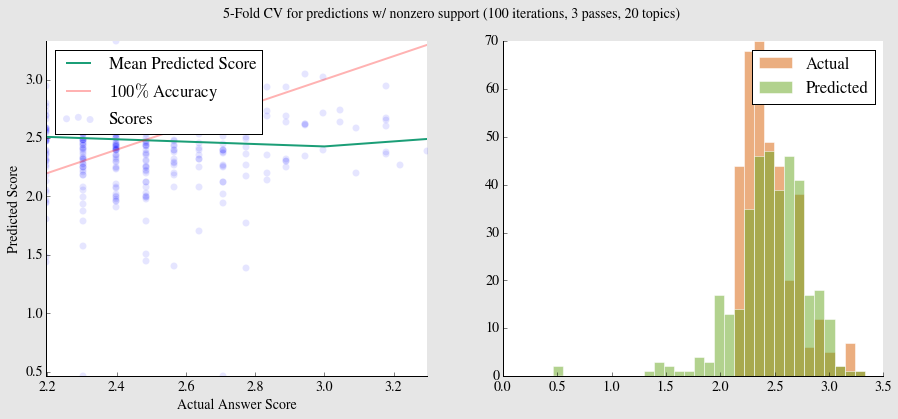


MSE:  0.115287044985
MAE:  0.245045154261
R^2 -1.13256492547


In [99]:
def scale(x):
    return np.log(x + 9)  
plot_results(results1[(results1.support > 0)], '5-Fold CV for predictions w/ nonzero support (100 iterations, 3 passes, 20 topics)')

# Cross-Validation (function w/ params)

In [28]:
def cv_recommender(k = 7, w = [1,1,1], num_topics = 20, iterations = 50, passes = 5):
    """
    Uses the n_fold train/test splits to validate with the given parameters. Outputs 
    a dataframe with columns 'actual' and 'predicted'.
    
    WARNING: super hacky!
    """
    
    # make a list of dataframes
    validate_dfs = range(n_folds)
    for j in range(n_folds):
        validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
        validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
        validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])
        
    for i in range(n_folds):
        validate_dfs[i]['predicted_score'] = 0.
        validate_dfs[i]['support'] = 0.

    for i in range(n_folds):
        recommender = Recommender(site_name, train_df_dicts[i])
        recommender.train(num_topics = num_topics, iterations = iterations, passes = passes)
        for j in range(len(validate_dfs[i])):
            pred_score, supp = recommender.predicted_score(validate_dfs[i].user_id.irow(j), 
                                                     validate_dfs[i][['title','question','tags']].irow(j),
                                                     k = k, w = w)
            validate_dfs[i]['predicted_score'][j] = pred_score
            validate_dfs[i]['support'][j] = supp
            
    results = pd.DataFrame(columns=['actual','predicted','support'])
    results.actual = pd.concat([vdf.score for vdf in validate_dfs])
    results.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])
    results.support = pd.concat([vdf.support for vdf in validate_dfs])
    
    return results

In [29]:
%%time
results2 = cv_recommender(num_topics=100, iterations=1000, passes=2)

CPU times: user 12min 32s, sys: 10.5 s, total: 12min 43s
Wall time: 6min 37s


LDA

    num_topics = 100
    iterations = 1000
    passes = 2
    k = 7
    w = [1,1,1] (title, question, tags)

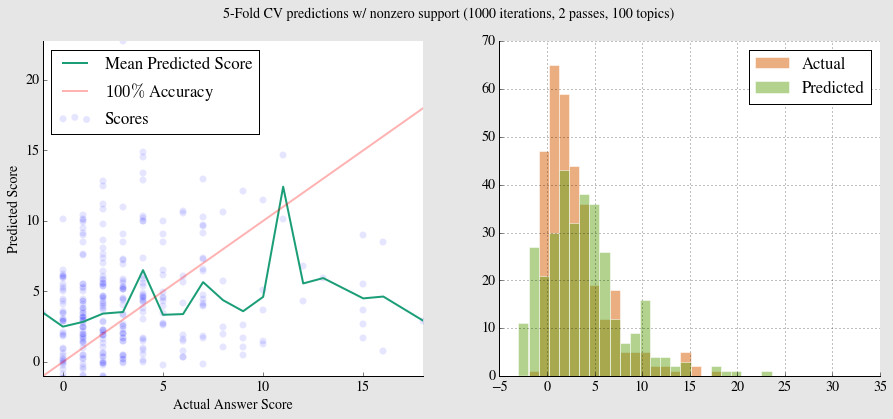

Regularized relative squared error (mean, std): (1.7310800083495304, 3.8583661532956648)
--------------------



In [30]:
plot_results(results2[results2.support >0], '5-Fold CV predictions w/ nonzero support (1000 iterations, 2 passes, 100 topics)')

Things to check/do:

1. keep some predictions with support 0? (need more features: comments, comment scores, reputation)
2. feed Tfidf vectors into LDA.